# Regression Analysis: Step 2 - Naive Modeling

## Overview
In this step, we proceed with the initial modeling phase, commonly known as "naive modeling". This involves several crucial stages to lay the foundation for more sophisticated analysis.

## Process
### 1. Dataset Import
We begin by importing the preprocessed dataset from the previous step. This dataset has undergone necessary cleaning and preparation.

### 2. Manual Feature Selection
Next, we perform manual feature selection based on correlation analysis. This step involves identifying and retaining features that demonstrate significant relationships with the target variable.

### 3. Variance Inflation Factor (VIF) Checking
To ensure the absence of multicollinearity issues, we conduct a variance inflation factor (VIF) check on the selected features. High VIF values indicate collinearity, which can distort regression results.

### 4. Pipeline Building
To streamline the modeling process and facilitate reproducibility, we construct a pipeline. This pipeline encapsulates various preprocessing steps and the regression model itself.

### 5. Linear Regression Modeling
Finally, we employ linear regression as the initial modeling technique. This simple yet powerful approach allows us to establish a baseline performance and understand the relationship between features and the target variable.

In [101]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [102]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((164, 25), (41, 25))

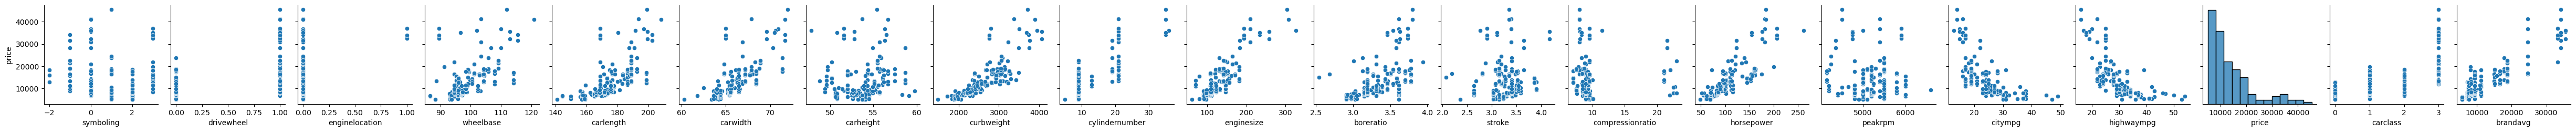

In [103]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars=["price"])
plt.show()

In [104]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

<Axes: >

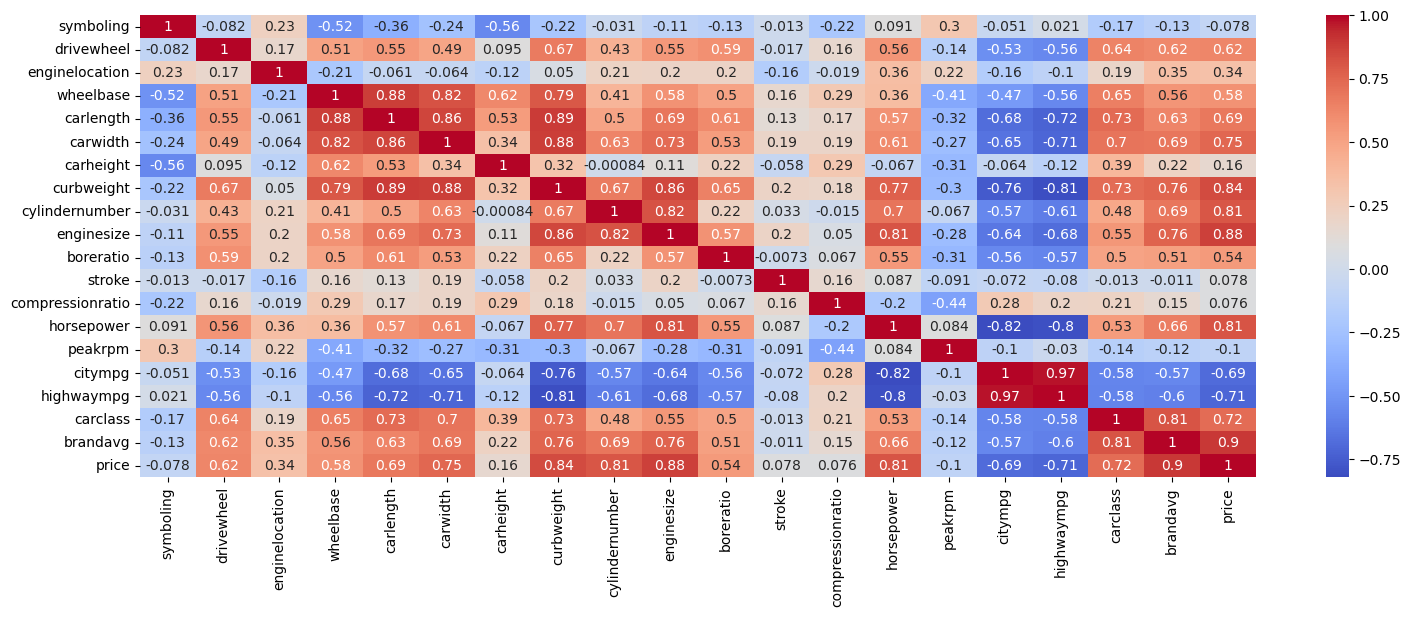

In [105]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm")

# Manual Feature Selection based on correlations

Dropping multicollinear features 0.85 threshold

In [106]:
train_data=train_data.drop(["carlength","carwidth","wheelbase","compressionratio","citympg"])
test_data=test_data.drop(["carlength","carwidth","wheelbase","compressionratio","citympg"])
to_remove = {"carlength","carwidth", "wheelbase", "compressionratio", "citympg"}

num_cols = list(set(num_cols) - to_remove)

Dropping Based on variance inflation factor

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].drop("price","car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2877.880266
9,enginesize,14.959196
3,curbweight,14.284160
5,horsepower,8.275155
7,brandavg,6.825451


In [108]:
train_data=train_data.drop("enginesize")
num_cols.remove("enginesize")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2693.019754
3,curbweight,12.925839
5,horsepower,6.594387
7,brandavg,6.023233
1,highwaympg,4.999216


In [109]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['symboling', 'drivewheel',
                                                   'enginelocation',
                                                   'carheight', 'curbweight',
                                                   'cylindernumber',
                                                   'boreratio', 'stroke',
                                                   'horsepower', 'peakrpm',
                                                   'highwaympg', 'carclass',
                                                   'brandavg'])])),
                ('lr', LinearRegression())])

Mean Test Score: 0.8630883258575621
Standard Deviation of Test Scores: 0.097981126321065
Mean absolute Error: 2515.0618235558327
R-squared on holdout set: 0.3364935380762417
Adjusted R-squared on holdout set: -0.20637538531592425


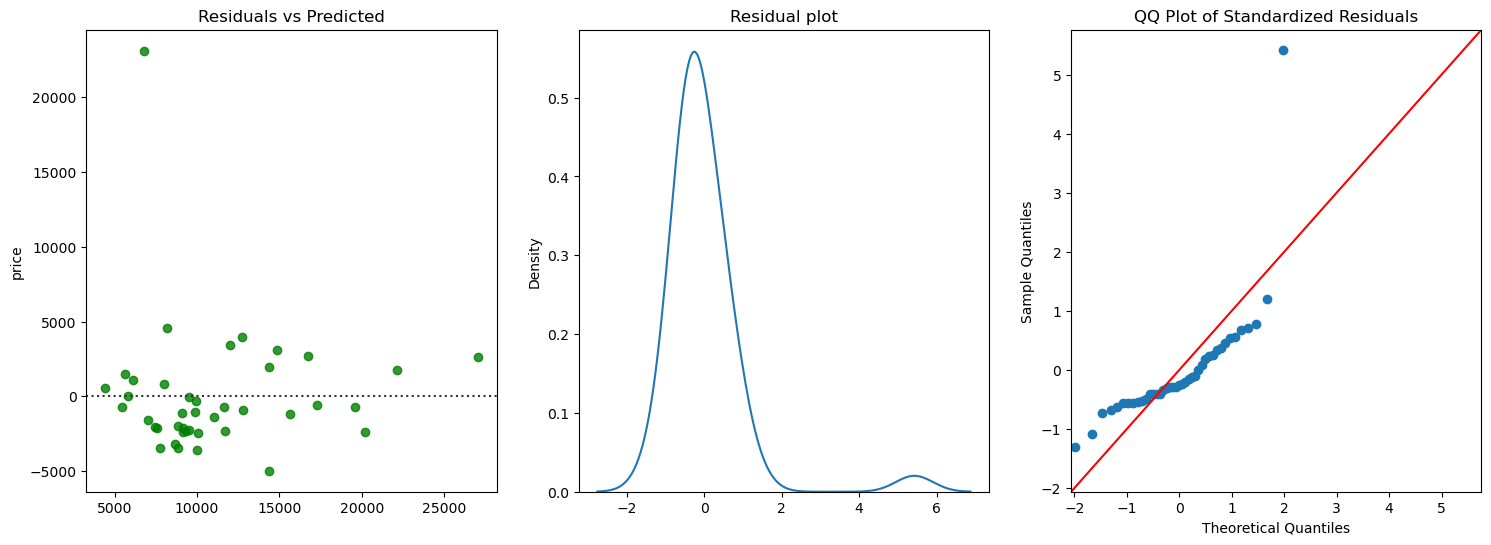

In [110]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',groups=X_train["aspiration"])
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

### Naive Modeling Performance Summary (Step 2)

#### Cross-Validation Results
- **Test Scores**: [0.90798197, 0.87235298, 0.88046931, 0.84110381, 0.71323683]
- **Training Scores**: [0.91582158, 0.92718239, 0.92254767, 0.92757397, 0.94165818]
- **Mean Test Score**: 0.8430289809289551
- **Standard Deviation of Test Scores**: 0.06830852820490455

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 2857.4640861402972
- **R-squared (R²)**: 0.7573543603642837
- **Adjusted R-squared**: 0.6710803551604735

### Insights
- **Consistency**: Cross-validation test scores demonstrate consistency with a mean R² of 0.8430 and a standard deviation of 0.0683, indicating moderate variability across different folds.
- **Overfitting**: The gap between training scores (average ~0.927) and test scores (average ~0.843) is smaller compared to previous results, but it still suggests potential overfitting.
- **Error Magnitude**: The MAE of 2857.46 on the holdout set indicates an improvement, showing that the model's predictions deviate from the actual values by an average of approximately 2857 units.
- **Holdout Set R²**: An R² of 0.7574 on the holdout set shows the model explains approximately 75.74% of the variance in the holdout data, indicating a good fit.
- **Adjusted R²**: The adjusted R² of 0.6711 on the holdout set suggests that when accounting for the number of predictors, the model explains around 67.11% of the variance, showing improved explanatory power while considering model complexity.